In [6]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [7]:
import numpy as np
import pandas as pd
# timedelta used in this notebook suggested by chatGPT
from datetime import datetime as dt, timedelta

# Reflect Tables into SQLAlchemy ORM

In [64]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [9]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [10]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine)

In [11]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [12]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [13]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [14]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23',)

<Figure size 1000x600 with 0 Axes>

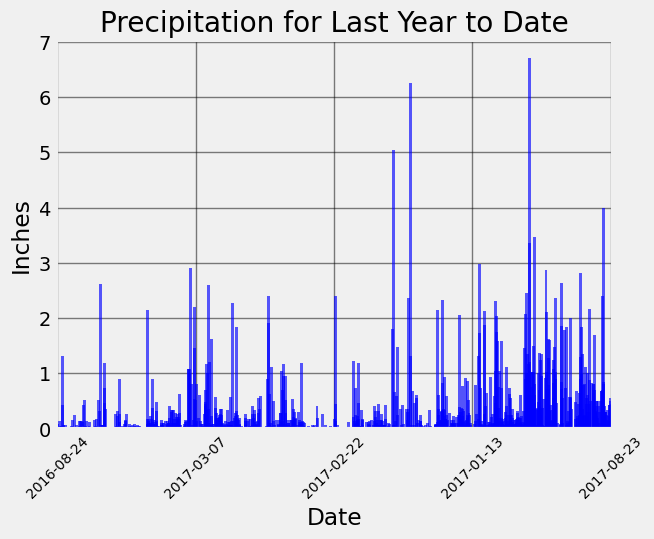

In [48]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
date = session.query(measurement.date).order_by(measurement.date.desc()).first()[0]
date = dt.strptime(date, "%Y-%m-%d")

# Calculate the date one year from the last date in data set.
#timedelta from chatGPT
year_to_date = date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp_results = session.query(measurement.date, measurement.prcp).filter(measurement.date >= year_to_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(prcp_results, 
                  columns=['date', 'precipitation score'])

# Sort the dataframe by date
prcp_df['date'] = pd.to_datetime(prcp_df['date'])
prcp_df.set_index('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))

prcp_df.plot(kind='bar', color='b', alpha=0.65, legend=False, align = 'center', width=12)
plt.grid(visible=True, which='major', axis='both', color='black', linestyle='-', linewidth=1, alpha=.5)
plt.title("Precipitation for Last Year to Date")
plt.xlabel("Date")
ticks_indices = np.linspace(0, len(prcp_df)-1, 5, dtype=int)
# Code for editing tick marks from chatGPT
plt.xticks(ticks_indices, [prcp_df.index[i].strftime("%Y-%m-%d") for i in ticks_indices], rotation=45, fontsize = 10)
plt.ylabel("Inches")
plt.show()


In [54]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_summary_results = session.query(measurement.prcp).all()
prcp_summary_df = pd.DataFrame(prcp_summary_results, columns=['precipitation score'])
summary_stats = prcp_summary_df.describe()

summary_stats

,precipitation score
count,18103.000000
mean,0.160644
std,0.468746
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,11.530000


# Exploratory Station Analysis

In [55]:
# Design a query to calculate the total number of stations in the dataset
qty_station_results = len(session.query(station.name).all())
qty_station_results

9

In [65]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations_results = session.query(measurement.station, func.count(measurement.station).label('station_count')).\
                        group_by(measurement.station).\
                        order_by(desc('station_count')).all()

active_stations_df = pd.DataFrame(active_stations_results, columns=['Station', 'Count'])
active_stations_df


,Station,Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [73]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
first_station_count = active_stations_df.iloc[0, 0]

active_stations_low = session.query(func.min(measurement.tobs)).filter(measurement.station == f'{first_station_count}').scalar()
active_stations_high = session.query(func.max(measurement.tobs)).filter(measurement.station == f'{first_station_count}').scalar()
active_stations_avg = session.query(func.avg(measurement.tobs)).filter(measurement.station == f'{first_station_count}').scalar()

active_stations_low, active_stations_high, active_stations_avg

(54.0, 85.0, 71.66378066378067)

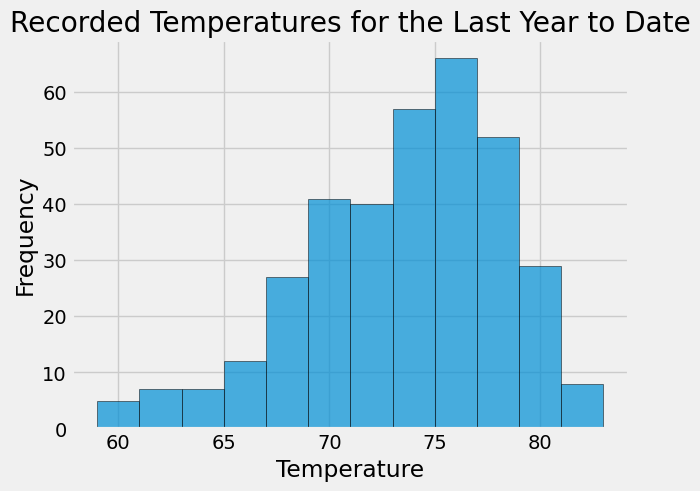

In [80]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_to_date_active = session.query(measurement.date, measurement.tobs).\
    filter(measurement.station == f'{first_station_count}').\
        filter(measurement.date >= year_to_date).all()
year_to_date_active

# Save the query results as a Pandas DataFrame. Explicitly set the column names
tobs_df = pd.DataFrame(year_to_date_active, 
                  columns=['date', 'temperature observation'])

# Sort the dataframe by date
tobs_df['date'] = pd.to_datetime(tobs_df['date'])
tobs_df.set_index('date', inplace=True)

tobs_df['temperature observation'].plot.hist(bins=12, edgecolor='black', alpha=0.7)

# Add labels and title
plt.title('Recorded Temperatures for the Last Year to Date')
plt.xlabel('Temperature')
plt.ylabel('Frequency')

# Show the plot
plt.show()

# Close Session

In [81]:
# Close Session
session.close()